# Using the HDX_LIMIT.pipeline subpackage
***

The purpose of this notebook is to provide explanation and usage examples for the modules of the pipeline subpackage of the HDX_LIMIT package. 

**The pipeline subpackage is used to extract signal corresponding to library proteins from known positions in each HDX timepoint, and process those signals into a best-estimate HDX-mass-addition time series for each library protein.**

>The subpackage relies on .mzML.gz files and library_info.csv from preprocessing, but no other inputs are needed.

>The pipeline modules work on top of the HDX_LIMIT.datatypes and .processing core-modules, and are designed to be context-flexible for use in Snakemake, command-line, and python contexts. 

**The pipeline subpackage performs three main tasks, each to its own module:**
1. Extracting protein signals from predetermined locations found in library_info.csv
2. Packaging extracted signals into custom classes that perform deconvolution
3. Selecting from pools of candidate signals to create a best-estimate HDX-mass-addition timeseries for each library protein identified.

**The two 'IdotP' modules: idotp_check and idotp_filter, are used in Snakemake to reduce the number of candidate signals to be processed.** 
>The idotp_check Snakefile extracts signal from all undeuterated replicates for each entry in library_info.csv, uses the core classes to clean and deconvolute the data, and measures the quality of the observed signal against the theoretical isotopic distribution determined from the given protein's sequence. 

>The measure of quality used is the dot product between the observed and theoretical normalized integrated m/Z distributions (range [0,1]), or 'isotopic dot product' shortened to 'idotp'. A lower threshold on idotp is given to idotp_filter, which returns a set of indices from library_info.csv with idotp >= threshold. Lines in library_info.csv with poor idotp are not considered for further processing, crucially reducing computational load. 

>Default values for the idotp threshold are ~0.99 for extremely-high-confidence, and ~0.95 for high-confidence. Thresholds should be as close to 1 as possible to avoid excessive load and garbage-in-garbage-out problems, while retaining the highest identification-rate possible. The idotp_filter module creates plots of the idotp distribution, which help in making informed choices about idotp threshold.

**The main output of the pipeline modules is the best-estimate hdx-mass-addition timeseries, contained in the PathOptimizer object as .winners, a list of IsotopeCluster objects. This is used in the estimation of per-residue exchange rates and $\Delta G_{unfolding}$ of library proteins.**

In [1]:
import os
import sys
import yaml
import glob
import numpy as np
import pandas as pd
import seaborn as sns

# Set matplotlib backend to work in jupyter.
import matplotlib
# matplotlib.use('nbAgg') # best for windows but works on Mac
matplotlib.use('MacOSX') # best for notebooks on Mac
import matplotlib.pyplot as plt
%matplotlib inline

# Make the Jupyter environment see workflow/scripts/.
sys.path.append('/'.join(os.getcwd().split('/')[:-1])+'/workflow/scripts') # default 'path/to/HDX_LIMIT-Pipeline/workflow/scripts/'
library_info = pd.read_csv('../resources/library_info/library_info.csv')
config = yaml.load(open('../config/config.yaml', 'rb').read(), Loader=yaml.FullLoader)

# Load and alias main functions of preprocessing modules
from HDX_LIMIT.pipeline.idotp_check import main as idotp_check
from HDX_LIMIT.pipeline.idotp_filter import main as idotp_filter
from HDX_LIMIT.pipeline.extract_timepoint_tensors import main as extract_timepoint_tensors
from HDX_LIMIT.pipeline.generate_tensor_ics import main as generate_tensor_ics
from HDX_LIMIT.pipeline.optimize_paths import main as optimize_paths

from HDX_LIMIT.io import limit_read, limit_write, optimize_paths_inputs

**Here we consider groups of charged species together as an 'rt-group': a group of all the observed charge states of a library protein, clustered in LC retention time.**<br>
This is necessary to limit the size of the LC extraction window, as our designed proteins have been observed to have bimodal elution profiles. RT-group names are assigned during the creation of the library_info.csv, and here we create sub-dataframes from library_info for each rt_group.

In [2]:
# Divide library_info into rt-group level dataframes
lib_names = list(set(library_info['name'].values))
lib_names = sorted(lib_names, key=lambda i: float(i.split('_')[-1]))

rt_group_dfs = {}
for name in lib_names:
    rt_group_dfs[name] = library_info.loc[library_info['name']==name]

***

## Extracting signals from .mzML.gz files

In [3]:
help(extract_timepoint_tensors)

Help on function main in module HDX_LIMIT.pipeline.extract_timepoint_tensors:

main(library_info_path, mzml_gz_path, timepoints_dict, outputs=None, return_flag=False, low_mass_margin=10, high_mass_margin=17, rt_radius=0.4, dt_radius_scale=0.06, polyfit_calibration_dict=None, indices=None)
    Reads through .mzML file and extracts subtensors whose dimensions are defined in 
       library_info.csv, optionally saves individual tensors or returns all as a dictionary.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        mzml_gz_path (str): path/to/timepoint.mzML.gz
        timepoints_dict (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        outputs (list of strings): list of filename strings for writing extracted outputs. 
        return_flag (bool): option to return main output in python, for notebook context
        low_mass_margin (

In [4]:
# Extract signal for a protein rt-group from an undeuterated MS run. 

# Select an rt-group by its lib_names index (sorted by LC-elution time), generate expected output filenames.
rt_group_name_idx = 13
indices_of_interest = rt_group_dfs[lib_names[rt_group_name_idx]]['Unnamed: 0'].values
desired_outputs = ['../resources/tensors/'+str(idx)+'_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib' for idx in indices_of_interest]

# Check if expected files are present, if not generate them. 
if all([len(list(glob.glob('../resources/tensors/'+str(idx)+'_*UN.*'))) > 0 for idx in indices_of_interest]): # only files from the replicate being used 
    rt_group_tensor_filenames = [fn for idx in indices_of_interest for fn in list(glob.glob('../resources/tensors/'+str(idx)+'_*'))]
    rt_group_undeut_filenames = [fn for fn in rt_group_tensor_filenames if 'UN.' in fn]
else:
    extract_timepoint_tensors(
        '../resources/library_info/library_info.csv', 
        '../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML.gz', 
        outputs=desired_outputs,
        timepoints_dict=config, 
        indices=indices_of_interest
    )
    if all([len(list(glob.glob('../resources/tensors/'+str(idx)+'_*UN.*'))) > 0 for idx in indices_of_interest]):
        rt_group_tensor_filenames = [fn for idx in indices_of_interest for fn in list(glob.glob('../resources/tensors/'+str(idx)+'_*'))]
        rt_group_undeut_filenames = [fn for fn in rt_group_tensor_filenames if 'UN.' in fn]

In [5]:
rt_group_undeut_filenames

['../resources/tensors/19_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib']

In [6]:
undeut_raw_tensors = [limit_read(fn) for fn in rt_group_undeut_filenames]

In [7]:
# These files contain ragged nested lists, the first two positions are lists of dimension labels for LC and IMS,
# and the third position contains the matricized intensity tensor along with each entry's m/Z label.
print('Overall output shape: \n'+str(np.shape(undeut_raw_tensors[0])))
print('Shape of each dimension:')
print(np.shape(undeut_raw_tensors[0][0]))
print(np.shape(undeut_raw_tensors[0][1]))
print(np.shape(undeut_raw_tensors[0][2]))
print('Shape of entry in mz-dimension: \n'+str(np.shape(undeut_raw_tensors[0][2][0])))

Overall output shape: 
(3,)
Shape of each dimension:
(48,)
(15,)
(720,)
Shape of entry in mz-dimension: 
(54, 2)


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



**The signals are 3D (LC-IMS-MS) arrays, and so are called tensors. These are saved as g-zipped pickle files, the filename of a tensor is passed to instances of the TensorGenerator class, and the explicit contents of the array are passed as arguments to the DataTensor class. These classes exist to simplify the user's role in the complex processing of these outputs.**

***
## Cleaning and deconvoluting extracted signals

**The generate_tensor_ics pipeline module is meant to fully abstract the signal processsing of the extracted tensors.** 

>Usually the only output is what will be used in generating the hdx-mass-addition time series: the list of IsotopeCluster objects identified from the input tensor. However in python contexts where the main function can be exposed (like this notebook), the return_flag argument can be used to return the TensorGenerator object from generate_tensor_ics. The TensorGenerator object contains a DataTensor object: the source of the IsotopeCluster objects, and more information than would be available with only the IsotopeCluster outputs. 

In [8]:
help(generate_tensor_ics)

Help on function main in module HDX_LIMIT.pipeline.generate_tensor_ics:

main(library_info_path, tensor_input_path, timepoints_dict, isotope_clusters_out_path=None, return_flag=False, gauss_params=(3, 1))
    Performs nonnegative tensor factorization to deconvolute input tensor, identifies IsotopeCluster objects, 
    and optionally returns or writes output list of IsotopeClusters.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        tensor_input_path (str): path/to/tensor.cpickle.zlib
        timepoints_dict (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        isotope_clusters_out_path (str): path/to/file for main output - list of IsotopeClusters objects
        return_flag (bool): option to return output in python, for notebook context
        gauss_params (tuple of ints/floats): Gaussian smoothing parameters in LC-RT and IMS-DT 

In [9]:
# Use the return flag and a list comprehension to build a list of TensorGenerator objects from one undeuterated MS run for one rt-group. 
# generate_tensor_ics automatically performs gaussian filtering on the LC and IMS dimensions, and performs tensor factorization to deconvolute signals.
undeut_tgs = []
for tensor_filename in rt_group_undeut_filenames:
    # Use 'TensorGenerator' key on the return to get object out of returned dictionary.
    undeut_tgs.append(generate_tensor_ics(library_info_path='../resources/library_info/library_info.csv', tensor_input_path=tensor_filename, timepoints_dict=config, isotope_clusters_out_path=None, return_flag=True)['TensorGenerator'])

Pre-Initialization: 0.16415023803710938
Post-Initialization: 0.17833709716796875
0 Start Process Memory (GB): 0.17833709716796875


/Users/rwl0960/Documents/hdx/HDX_LIMIT-Pipeline/workflow/scripts/HDX_LIMIT/datatypes.py:42: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



1 Read Params Process Memory (GB): 0.1820526123046875
2 Zeroing Process Memory (GB): 0.1820526123046875
3 Pre-Factorization Process Memory (GB): 0.1820526123046875
4 13 Factors  Start Process Memory (GB): 0.1820526123046875
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/nn_fac/ntf.py:308: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



4 13 Factors  End Process Memory (GB): 0.20350265502929688
5 12 Factors  Start Process Memory (GB): 0.2035369873046875
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
5 12 Factors  End Process Memory (GB): 0.2071990966796875
6 11 Factors  Start Process Memory (GB): 0.2071990966796875
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
6 11 Factors  End Process Memory (GB): 0.2071990966796875
7 10 Factors  Start Process Memory (GB): 0.20720291137695312
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been s

In [71]:
undeut_tgs # stores the list of TensorGenerators

In [72]:
# TensorGenerator objects store a DataTensor as TensorGenerator.DataTensor.
undeut_tgs[0].DataTensor

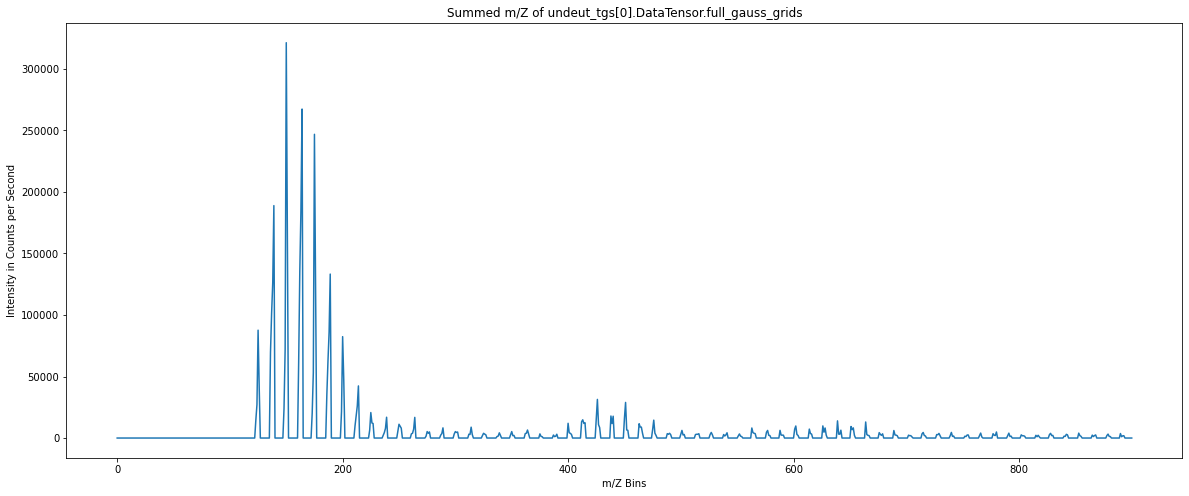

In [78]:
# DataTensor.full_gauss_grids contains the processed 3D numpy array of LC-IMS-MS intensity data.
fig = plt.figure(figsize=(20,8))
ax1=fig.add_subplot(111)
plt.plot(np.sum(undeut_tgs[0].DataTensor.full_gauss_grids, axis=(0,1)))
ax1.set(title='Summed m/Z of undeut_tgs[0].DataTensor.full_gauss_grids', xlabel='m/Z Bins', ylabel='Intensity in Counts per Second')
plt.show()
plt.close()

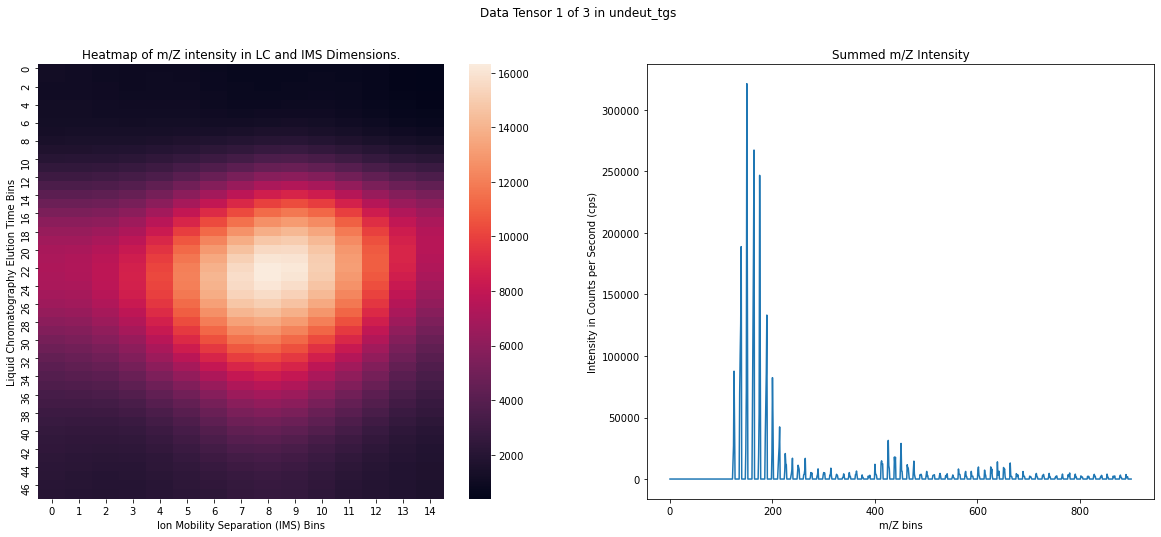

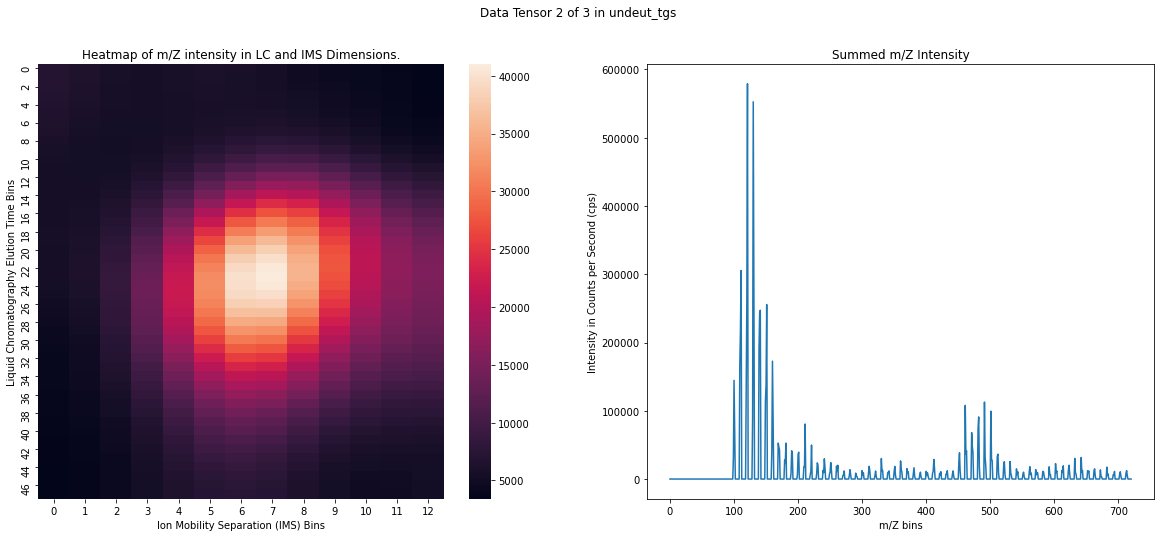

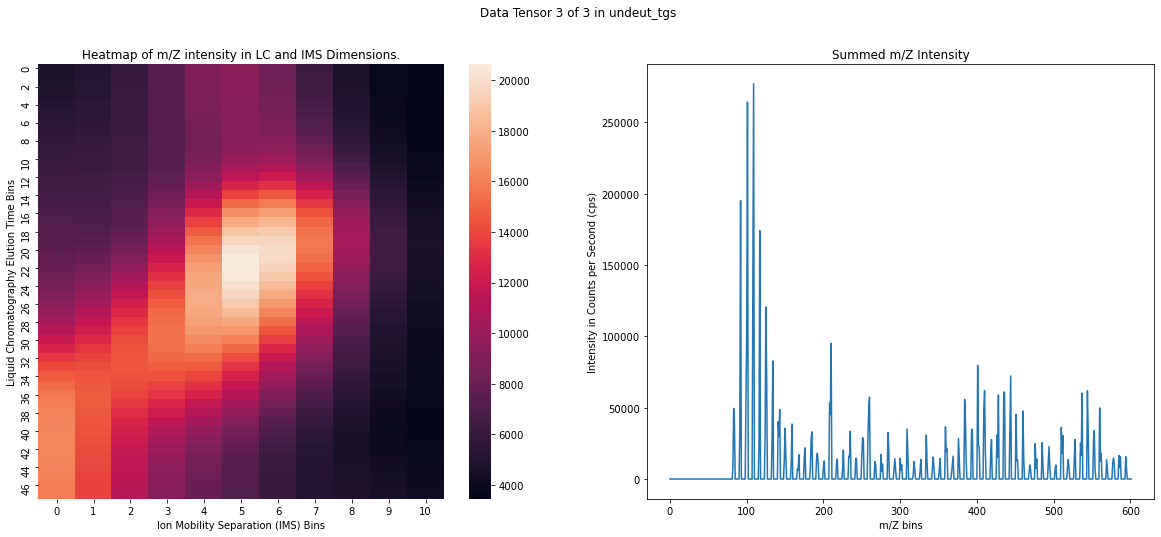

In [79]:
# Heatmaps and mass spectra for undeut_tgs
for i in range(len(undeut_tgs)):
    fig = plt.figure(figsize=(20,8))
    fig.suptitle('Data Tensor '+str(i+1)+' of '+str(len(undeut_tgs))+' in undeut_tgs')
    
    ax1 = fig.add_subplot(121)
    ax1 = sns.heatmap(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=2), ax=ax1)
    ax1.set(title='Heatmap of m/Z intensity in LC and IMS Dimensions.', xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography Elution Time Bins")
    
    ax2 = fig.add_subplot(122)
    plt.plot(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=(0,1)))
    ax2.set(title='Summed m/Z Intensity', xlabel='m/Z bins', ylabel='Intensity in Counts per Second (cps)')

**The DataTensor object performs gaussian smoothing and tensor-factorization to clean and deconvolute the input.**<br>
This is useful in our experimental setup where we test many designs of a few structural folds, and signals can be crowded in separation space. Convoluted signals in the DataTensor are resolved by tensor factorization, and the resulting factors are packaged as instances of the Factor class and stored as a list in the  DataTensor.factors attribute. 

In [1]:
for i in range(len(undeut_tgs)):
    fig = plt.figure(figsize=(20,8))
    fig.suptitle('DataTensor '+str(i)+' of '+str(len(undeut_tgs)))
    ax1 = fig.add_subplot(121)
    ax1 = sns.heatmap(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=2), ax=ax1)
    ax1.set(title='Heatmap of m/Z Intensity in Extracted LC and IMS Region', xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography (LC) Elution Time Bins")

    ax2 = fig.add_subplot(122)
    ax2 = fig.add_subplot(122)
    plt.plot(np.sum(undeut_tgs[i].DataTensor.full_gauss_grids, axis=(0,1)))
    ax2.set(title='Sum of intensity in m/Z over LC and IMS', xlabel='m/Z bins', ylabel='Intensity in Counts per Second (cps)')
    
    for j in range(len(undeut_tgs[i].DataTensor.factors)):
        fig = plt.figure(figsize=(20,16))
        fig.suptitle('Tensor '+str(i)+ ', Factor '+str(j)+' of '+str(len(undeut_tgs[i].DataTensor.factors)))

        ax1 = fig.add_subplot(221)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].mz_data)
        ax1.set(title='Heatmap of m/Z Intensity in Extracted LC and IMS Region', xlabel="Ion Mobility Separation (IMS) Bins", ylabel = "Liquid Chromatography (LC) Elution Time Bins")

        ax2 = fig.add_subplot(222)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].integrated_mz_data)
        ax2.set(title='Summed m/Z Intensity', xlabel='m/Z bins', ylabel='Intensity in counts per second (cps)')
        
        ax3 = fig.add_subplot(223)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].rts)
        ax3.set(title='Summed m/Z Intensity', xlabel='m/Z bins', ylabel='Intensity in counts per second (cps)')
        
        ax4 = fig.add_subplot(224)
        plt.plot(undeut_tgs[i].DataTensor.factors[j].dts)
        ax3.set(title='Summed m/Z Intensity', xlabel='m/Z bins', ylabel='Intensity in counts per second (cps)')

NameError: name 'undeut_tgs' is not defined

identifies isotope-cluster-like signals inside the resulting factors, and stores them internally as IsotopeCluster objects. These are collected and output automatically in Snakemake, but need to be accessed manually in the python context.**

In [47]:
# Collect IsotopeClusters from all Factors of all undeuterated DataTensors
undeut_ics = []
for tg in undeut_tgs:
    for factor in tg.DataTensor.factors:
        for ic in factor.isotope_clusters:
            undeut_ics.append(ic)

LC-dimension labels:
[5.06829977 5.08521652 5.10211658 5.11901665 5.1359334  5.15283346
 5.16973352 5.1866498  5.20354986 5.22046661 5.23736668 5.25426674
 5.27118349 5.28808355 5.30499983 5.32189989 5.33879995 5.35571671
 5.37261677 5.38953352 5.40643311 5.42333317 5.44024992 5.45714998
 5.47406673 5.4909668  5.50786686 5.52478313 5.5416832  5.55859995
 5.57550001 5.59240007 5.60931683 5.62621689 5.64313316 5.66003323
 5.67693329 5.69385004 5.7107501  5.72766685 5.74456644 5.7614665
 5.77838326 5.79528332 5.81220007 5.82910013 5.84600019 5.86291647]

IMS-dimension labels:
[8.37950139 8.44875346 8.51800554 8.58725762 8.6565097  8.72576177
 8.79501385 8.86426593 8.93351801 9.00277008 9.07202216 9.14127424
 9.21052632 9.27977839 9.34903047]

m/Z labels:
[1276.40380859 1276.42380859] ... [1294.38380859 1294.40380859]





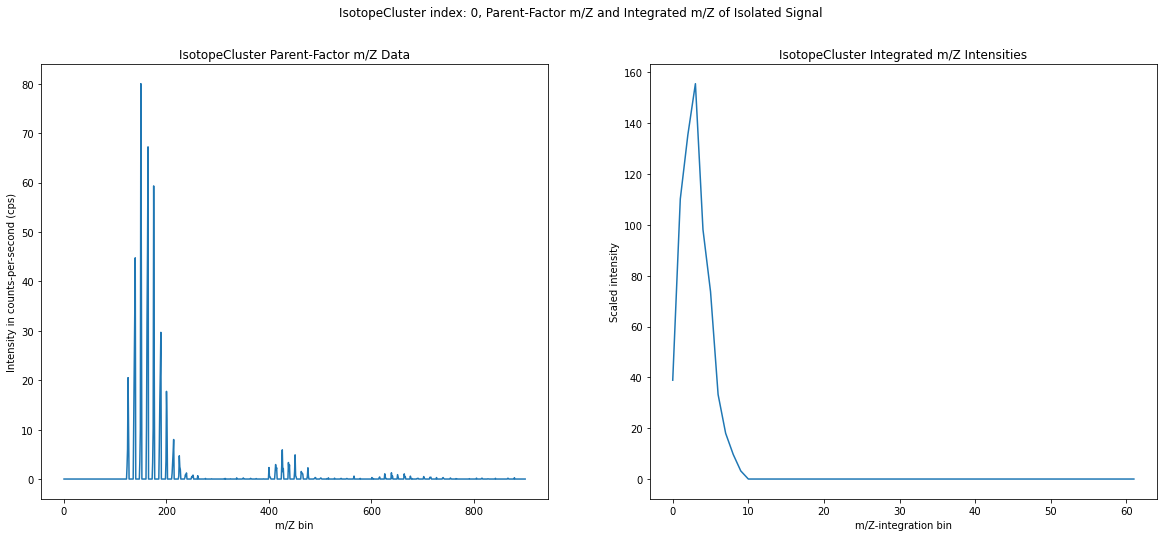

In [50]:
# Display IsotopeCluster data and dimension labels.
# The IsotopeCluster objects contain information about their parent factor, positions in each dimension, and processed m/Z signal.

my_ic_idx = 0
my_ic = undeut_ics[my_ic_idx]

print('LC-dimension labels:')
print(my_ic.retention_labels)
print('\nIMS-dimension labels:')
print(my_ic.drift_labels)
print('\nm/Z labels:')
print(str(my_ic.mz_labels[:2])+' ... '+str(my_ic.mz_labels[-2:])+'\n\n\n')

fig = plt.figure(figsize=(20,8))
plt.suptitle("IsotopeCluster index: "+str(my_ic_idx)+', Parent-Factor m/Z and Integrated m/Z of Isolated Signal')

ax1 = fig.add_subplot(121)
plt.plot(my_ic.factor_mz_data)
ax1.set(title='IsotopeCluster Parent-Factor m/Z Data', xlabel='m/Z bin', ylabel='Intensity in counts-per-second (cps)')

ax2 = fig.add_subplot(122)
plt.plot(my_ic.baseline_integrated_mz)
ax2.set(title='IsotopeCluster Integrated m/Z Intensities', xlabel='m/Z-integration bin', ylabel='Scaled intensity')

plt.show()
plt.close()

In [117]:
# This will take a long time to run, consider extracting all indices once instead as they're space efficient.
# Run extract_timepoint_tensors on all timepoints, for a single rt-group, or remove indices argument to extract all lines of library_info.
rt_group_name_idx = 13
indices_of_interest = rt_group_dfs[lib_names[rt_group_name_idx]]['Unnamed: 0'].values
required_inputs = ['../resources/mzml/'+mzml+'.gz' for timepoint in config['timepoints'] for mzml in config[timepoint]]
# desired outputs stored as mzml-wise lists of outpaths.
desired_outputs = [['../resources/tensors/'+str(idx)+'_'+mzml+'.gz.cpickle.zlib' for idx in indices_of_interest] for timepoint in config['timepoints'] for mzml in config[timepoint]]

for mzml, outputs in zip(required_inputs, desired_outputs):
    extract_timepoint_tensors(
        '../resources/library_info/library_info.csv', 
        mzml, 
        outputs=outputs,
        timepoints_dict=config, 
        indices=indices_of_interest
    )

3872784384
3915374592
9.5367431640625e-07 ../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML.gz
0 lines, time: 66.5287537574768
100 lines, time: 66.5319139957428
200 lines, time: 66.53223586082458
300 lines, time: 66.53252387046814
400 lines, time: 66.53277397155762
500 lines, time: 66.53305792808533
600 lines, time: 66.53334999084473
700 lines, time: 66.53395295143127
800 lines, time: 66.53422784805298
900 lines, time: 66.53451490402222
1000 lines, time: 66.53480291366577
1100 lines, time: 66.53530693054199
1200 lines, time: 66.53556084632874
1300 lines, time: 66.53580212593079
1400 lines, time: 66.53606700897217
1500 lines, time: 66.5365219116211
1600 lines, time: 66.53678297996521
1700 lines, time: 66.53709483146667
N Scans: 1872
3959259136
3993268224
69.90673899650574 ../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML.gz
24485 3.7228736877441406 0.0
Library Index: 21 Len Output: 0
24486 3.7249908447265625 0.0005698005698005698
Library Index: 21 Len Output: 1
24487 3.7250938415527344 0.

In [121]:
# This will take a long time to run, do not use on rt-groups with many charge states. 
# Generate DataTensors and store their IsotopeClusters for the PathOptimizer
all_rt_group_ics = []
for tp in desired_outputs: # desired_outputs is the list of all rt-group TensorGenerator inputs. 
    timepoint_ics = []
    for fn in tp:
        outpath = "../resources/subtensor_ics/"+fn.split('/')[-1]
        tg = generate_tensor_ics(library_info_path='../resources/library_info/library_info.csv', tensor_input_path=fn, timepoints_dict=config, isotope_clusters_out_path=outpath, return_flag=True)['TensorGenerator']
        for factor in tg.DataTensor.factors:
            for ic in factor.isotope_clusters:
                timepoint_ics.append(ic)
    all_rt_group_ics.append(timepoint_ics)

Pre-Initialization: 1.1624031066894531
Post-Initialization: 1.1751441955566406
0 Start Process Memory (GB): 1.1751441955566406
1 Read Params Process Memory (GB): 1.1786842346191406
2 Zeroing Process Memory (GB): 1.1786842346191406
3 Pre-Factorization Process Memory (GB): 1.1786842346191406
4 13 Factors  Start Process Memory (GB): 1.1786842346191406
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
4 13 Factors  End Process Memory (GB): 1.1974754333496094
5 12 Factors  Start Process Memory (GB): 1.1975364685058594
Irrelevant number of sparsity coefficient (different from the number of modes), they have been set to None.
Irrelevant number of normalization booleans (different from the number of modes), they have been set to False.
5 12 Factors  End Process Memory (GB): 1.1969337463378906
6 11 Factors  Start Process Memory 

***
## Generating a best-estimate hdx-mass-addition time series

**The hdx time series estimation is performed by instances of the PathOptimizer class. They take in all IsotopeClusteres from all charge-states of an rt-group, sample a starting set of plausible mass-addition curves, and optimize those starting curves by scoring with reference to the undeuterated ground-truth signal.**

The HDX_LIMIT.pipeline.optimize_paths module simply wraps PathOptimizer class for simple, easy instantiation.  

In [160]:
help(optimize_paths)

Help on function main in module HDX_LIMIT.pipeline.optimize_paths:

main(library_info_path, all_tensor_input_paths, timepoints, return_flag=False, rt_group_name=None, old_data_dir=None, html_plot_out_path=None, winner_out_path=None, runner_out_path=None, undeut_ground_out_path=None, winner_scores_out_path=None, rtdt_com_cvs_out_path=None)
    Uses PathOptimzier class to generate best-estimate hdx-timeseries of IsotopeClusters for a given library protein.
    
    Args:
        library_info_path (str): path/to/library_info.csv
        all_tensor_input_paths (list of strings): list of paths/to/files.cpickle.zlib for all lists of IsotopeClusters from generate_tensor_ics.py
        timepoints (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        return_flag: option to return main output in python, for notebook context
        rt_group_name (str): library_info['nam

In [7]:
# The io module function optimize_paths_inputs creates the flat list of IsotopeCluster-list files for an rt-group. This is sorted by the module.
ic_ins = optimize_paths_inputs(lib_names[rt_group_name_idx], library_info, config)
ic_ins = ['../'+fn for fn in ic_ins] # preprend ../ to adjust for working in /notebooks
print(len(ic_ins))

69


In [14]:
# Very slow, consider filtering to reduce total length of IC inputs
# Use the optimize_paths module on ICs from an rt-group to return a PathOptimizer object.
p1 = optimize_paths(
    '../resources/library_info/library_info.csv', 
    ic_ins, 
    config, 
    return_flag=True, 
    rt_group_name=lib_names[rt_group_name_idx], 
    html_plot_out_path='test_po_plot.html')['path_optimizer'] # output is a dictionary, use known key

**The optimize_paths module can output an interactive plot of the best-estimate time series as a .html file. This plot shows how each score term of the PathOptimizer contributed to the selection of one candidate IsotopeCluster over the others.**

***
## Using idotp_check to judge signal quality

**The idotp_check module performs a test on an extracted undeuterated signal to determine its similarity to the theoretical signal for the library protein sequence. This is the dot-product between the observed and theoretical isotope distributions, and so is shortened to 'idotp'.**
>Since our method estimates LC and IMS positions in deuterated-MS runs from the undeuterated signal, we ensure that the signals we are extrapolating from are high quality before moving on with the computationally intensive processing of deuterated signals. 

>In the provided idotp_check snakefile all undeuterated protein are extracted, ensuring that only signals with high-undeuterated-idotp are extracted from later hdx time points, reducing disk usage.


In [69]:
help(idotp_check)

Help on function main in module HDX_LIMIT.pipeline.idotp_check:

main(library_info_path, undeut_tensor_path_list, output_path=None, return_flag=None, n_factors=15, gauss_params=(3, 1))
    Compares each undeuterated charge state of an rt-group to its theoretical distribution to determine signal quality.
    
    Args:
        library_info_path (string): path/to/library_info.csv
        undeut_tensor_path_list (list of strings): list of paths/to/files.cpickle.zlib
        output_path (string): path/to/output.csv
        return_flag (bool): option to return output in python, for notebook context
        n_factors (int): high number of factors to start factorization with
        gauss_params (tuple of floats): gaussian smoothing parameters in tuple (rt-sigma, dt-sigma), default (3,1)
    
    Returns:
        iso_cluster_list (list): list of IsotopeCluster objects produced from factorized input tensors
        data_tensor_list (list): list of DataTensor objects produced from input tensor 

In [73]:
# In the python context, use glob to capture all undeuterated tensors, or restrict to a subset of library_info indices.
all_undeut_tensors = list(glob.glob('../resources/tensors/*UN*'))
rt_group_undeut_tensors = [fn for idx in indices_of_interest for fn in all_undeut_tensors if '/'+str(idx)+'_' in fn]

# Write a set of expected filenames to test.
all_expected_rt_group_tensors = ['../resources/tensors/'+str(index)+'_'+fn+'.gz.cpickle.zlib' for timepoint in config['timepoints'] for fn in config[timepoint] for index in indices_of_interest]
undeut_expected_rt_group_tensors = [fn for idx in indices_of_interest for fn in all_expected_rt_group_tensors if '/'+str(idx)+'_' in fn and 'UN' in fn]

In [74]:
# Check for expected undeuterated files in globbed list
all([fn in all_undeut_tensors for fn in undeut_expected_rt_group_tensors])

True

In [84]:
rt_group_undeut_tensors

['../resources/tensors/19_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/19_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib',
 '../resources/tensors/19_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib',
 '../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib',
 '../resources/tensors/21_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib']

In [77]:
# Run idotp_check on all charge states of an rt_group
idc = idotp_check('../resources/library_info/library_info.csv', rt_group_undeut_tensors, return_flag=True)

['../resources/tensors/19_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/19_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib', '../resources/tensors/19_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib', '../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib', '../resources/tensors/21_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib']
0 Start Process Memory (GB): 0.22813796997070312
1 Read Params Process Memory (GB): 0.2318572998046875
2 Zeroing Process Memory (GB): 0.2318572998046875
3 Pre-Factorization Process Memory (GB): 0.2318572998046875
4 15 Factors  Start Process Memory (GB): 0.2318572998046875
Irrelevant number of sparsity coefficient (different f

In [78]:
# idc is a dictionary
idc.keys()

dict_keys(['iso_clusters_list', 'data_tensor_list', 'idotp_list', 'integrated_mz_list'])

In [86]:
# The total number of IsotopeClusters identified from the input tensors
len(idc['idotp_list'])

824

In [96]:
# Count and percent of total for IsotopeClusters with idotp > 0.95 and 0.99
(len([idotp for idotp in idc['idotp_list'] if idotp>0.95]), 
 len([idotp for idotp in idc['idotp_list'] if idotp>0.95])/len(idc['idotp_list'])*100, 
 len([idotp for idotp in idc['idotp_list'] if idotp>0.99]), 
 len([idotp for idotp in idc['idotp_list'] if idotp>0.99])/len(idc['idotp_list'])*100)

(71, 8.616504854368932, 15, 1.820388349514563)

../resources/tensors/20_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib


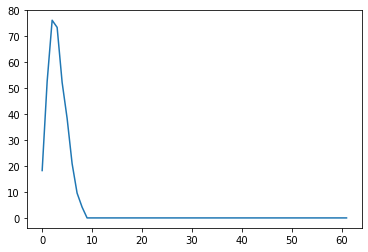

In [103]:
# Plot IsotopeCluster with highest idotp and print sourcefile.
best_idx = np.argmax(idc['idotp_list'])
print(idc['iso_clusters_list'][best_idx].source_file)
plt.plot(idc['iso_clusters_list'][best_idx].baseline_integrated_mz)

0.9916463002373997


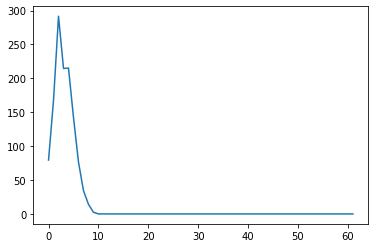

0.9912131421350864


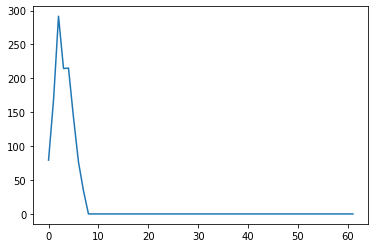

0.9948669424320942


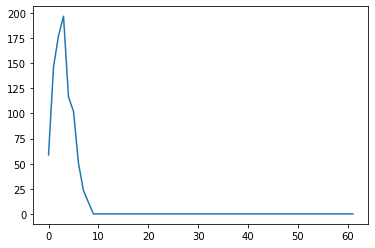

0.9923624731449346


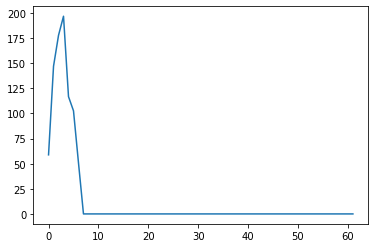

0.9967651993804943


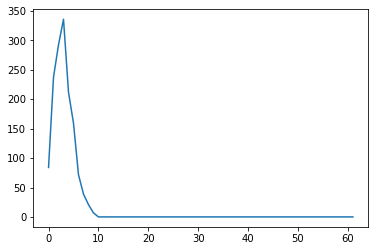

0.9908642121060086


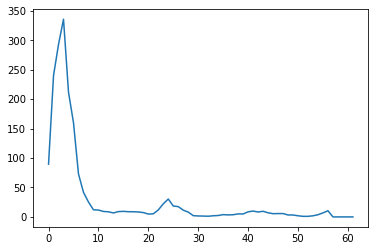

0.9942577665291881


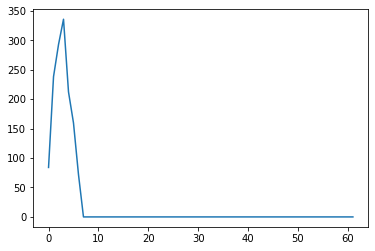

0.9924051308344518


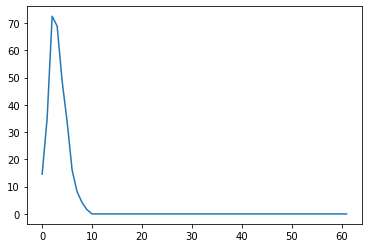

0.9971533897785265


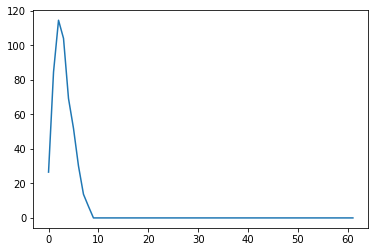

0.9935263262184206


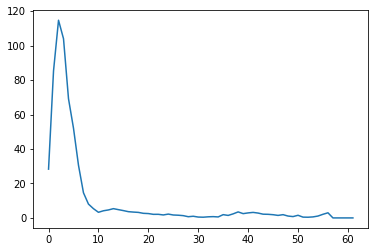

0.9946574625361586


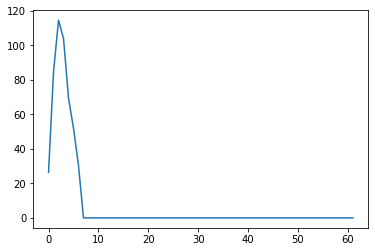

0.9990264538353882


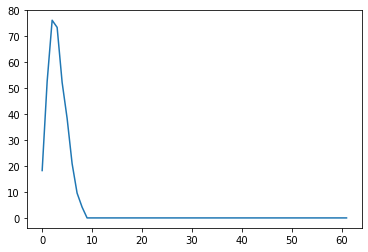

0.9950285318836749


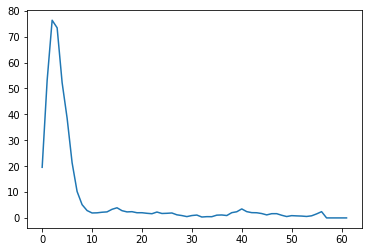

0.9965076136166259


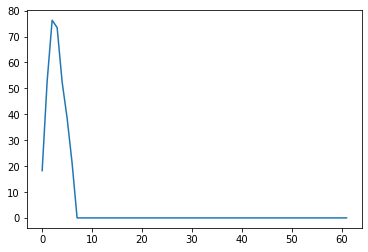

0.9911876088387782


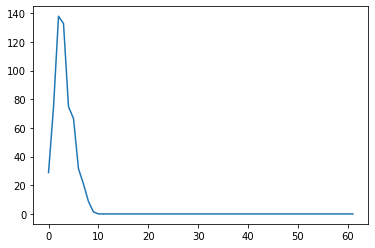

In [105]:
# Plot ICs with idotp>0.99
for ic, idotp in zip(idc['iso_clusters_list'], idc['idotp_list']):
    if idotp > 0.99:
        print(idotp)
        plt.figure()
        plt.plot(ic.baseline_integrated_mz)
        plt.show()
        plt.close()

***
## Ignoring poor signals with idotp_filter

**The idotp_filter is a very simple module that reads the set of all idotp_check output .csv files, and returns a list of library_info indices with idotp. The list of indices is passed as an argument to extract**

There be text

In [106]:
help(idotp_filter)

Help on function main in module HDX_LIMIT.pipeline.idotp_filter:

main(all_idotp_csv_inputs, out_path=None, return_flag=False, idotp_cutoff=0.95)
    Reads all rt-group idotp csvs and returns or saves a list of indices with idotp >= idotp_cutoff.
    
    Args:
        all_idotp_csv_inputs (list of strings): list of all input IsotopeCluster-list filepaths
        out_path (str): path/to/file for main output.cpickle.zlib
        return_flag (bool): option to return main output in python, for notebook context
        idotp_cutoff (float): inclusive lower-bound on idotp [0,1] to be considered for evaluation, default=0.95
    
    Returns:
        out_dict (dict) = dictionary containing 'filter_passing_indices'

